In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import logging
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from torch import optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.modules import *
# from torch.utils.tensorboard import SummaryWriter
from utils.paths import ROOT, DATA_DIR, RAW_DIR, PROCESSED_DIR, EQUITY_DIR

## Preprocess data

#### Read a CSV file

In [2]:
pth = os.path.join(EQUITY_DIR, "1d", "AAPL.csv")
cols = ["Date", "Close", "High", "Low", "Open", "Volume"]

df = pd.read_csv(pth, skiprows=2)
df.columns = cols

# Covert from Date feature as index of dataframe
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# Display
df.head(5)

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.261047,24.729270,23.821672,24.718174,212818400
2015-01-05,23.577574,24.110150,23.391173,24.030263,257142000
2015-01-06,23.579794,23.839424,23.218085,23.641928,263188400
2015-01-07,23.910433,24.010290,23.677430,23.788384,160423600
2015-01-08,24.829119,24.886815,24.121236,24.238848,237458000


<Axes: xlabel='Date'>

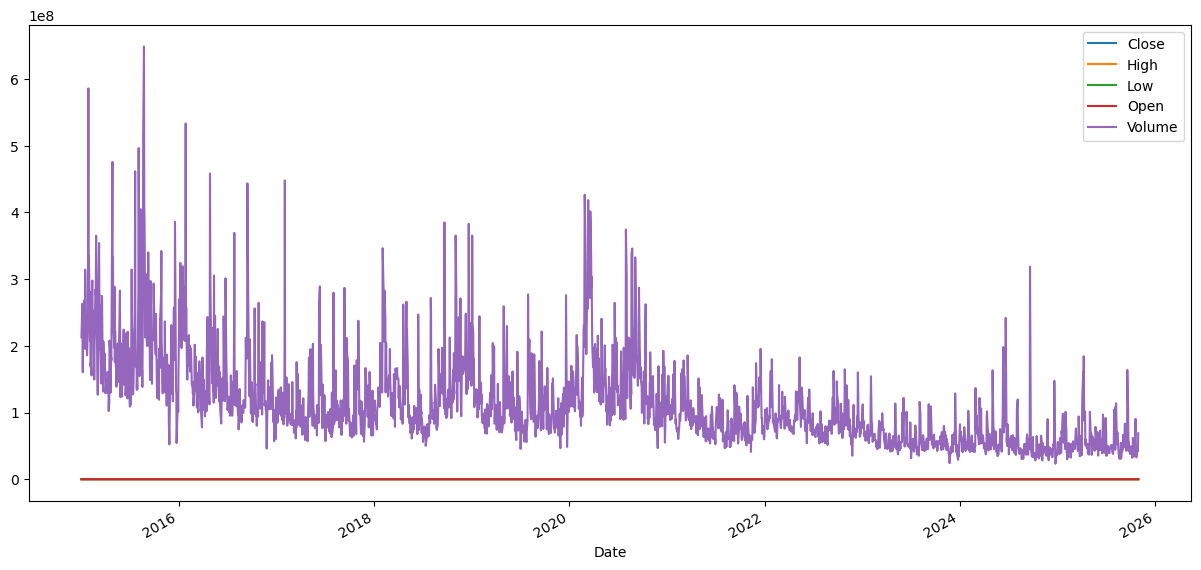

In [3]:
df.plot(figsize=(15, 7))

In [4]:
# tf means time frame or time range
cols_mask = ["Close", "Volume"]
tf_mask = (df.index >= dt.datetime(2020, 1, 1)) & (df.index <= dt.datetime(2025, 12, 31))

mh_df = df[cols_mask]
mh_df = mh_df.iloc[tf_mask]

mh_df.head(5)

,Close,Volume
Date,,
2020-01-02,72.538536,135480400
2020-01-03,71.833290,146322800
2020-01-06,72.405701,118387200
2020-01-07,72.065147,108872000
2020-01-08,73.224419,132079200


#### Time Bars
$\large r_t = \ln\left(\frac{P_{\text{Close},t}}{P_{\text{Close},t-1}}\right)$

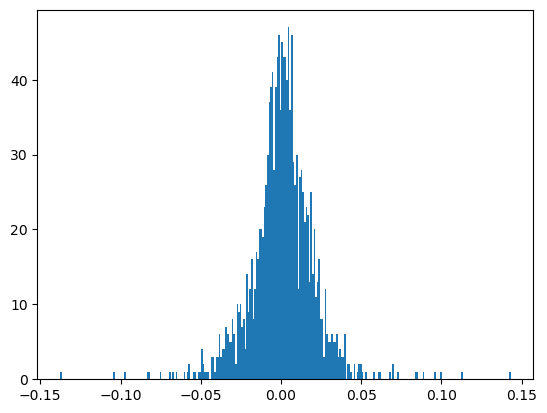

In [5]:
time_bars_price = mh_df.copy()
time_bars = np.log(time_bars_price["Close"] / time_bars_price["Close"].shift(1)).dropna()

bin_len = 0.001 # means size = 0.1%
plt.hist(time_bars, bins=np.arange(min(time_bars), max(time_bars) + bin_len, bin_len))
plt.show()

## Diffusion Model

### DDPM
* Variance: $\beta_t = \beta_{\text{start}} + (t-1) \frac{\beta_{\text{end}} - \beta_{\text{start}}}{T-1} \quad \text{for} \quad t = 1, \ldots, T$
* Noise: $\alpha = 1 - \beta$
* The cumulative product of all $\alpha$ up to $t$: $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$

#### Forward Process: 
* $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$
* $\epsilon$ (noise)
<br>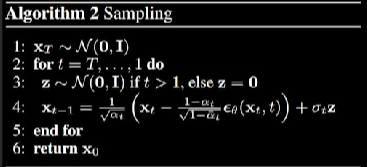

#### Reverse Process:
* $x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sqrt{\beta_t} z$
<br>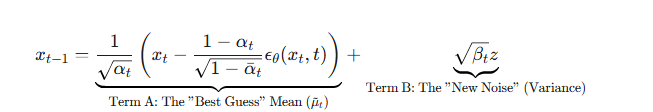
<br>
What is [:, None, None, None]? <br>
This is a "technique" of dimensionality expansion. $t$ is just a number (1D), but $x$ is an image (4D: Batch, Channel, H, W).None will expand the dimensionality of $\sqrt{\bar{\alpha}_t}$ from (Batch,) to (Batch, 1, 1, 1) so that it can be "multiplied" (broadcast) correctly with the image tensors (Batch, 3, 256, 256).

In [6]:
# logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

# class Diffusion:
#     def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, length=256, num_features=2, device="cuda"):
#         self.noise_steps = noise_steps
#         self.beta_start = beta_start
#         self.beta_end = beta_end
#         self.length = length
#         self.device = device

#         # Must Specifice number of features.
#         self.num_features = num_features

#         self.beta = self.prepare_noise_schedule().to(device)
#         self.alpha = 1 - self.beta
#         self.alpha_hat = torch.cumprod(self.alpha, dim=0)

#     def prepare_noise_schedule(self):
#         # numpy.linspace(start, stop, num) such as numpy.linspace(0, 10, 5) -> [0.0,2.5,5.0,7.5,10.0]
#         return torch.linspace(self.beta_start, self.beta_end, self.noise_steps) 

#     def noise(self, x, t):
#         # Reshape Batch -> (N,....)?  
#         sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
#         sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[i])[:, None, None, None]
#         E = torch.randn_like(x)
#         return (sqrt_alpha_hat * x) + (sqrt_one_minus_alpha_hat * E), E

#     def sample_timesteps(self, n):
#         # low = 1 if high = 1000 rand values between -1 to 999
#         return torch.randint(low=1, high=self.noise_steps, size=(n,))

#     def sample(self, model, n):
#         logging.info(f"Sampling {n} new images....")
#         model.eval()
#         with torch.no_grad():
#             x = torch.rand( (n, self.length, self.num_features)).to(self.device)
#             for i in tdqm(reversed(range(1, self.noise_steps)), position=0):
#                 t = (torch.ones(n) * i).long().to(self.device)
#                 predicted_noise = model(x, t)
#                 alpha = self.alpha[t][:, None, None, None]
#                 alpha_hat = self.alpha_hat[t][:, None, None, None]
#                 beta = self.beta[t][:, None, None, None]
#                 if i > 1:
#                     noise = torch.randn_like(x)
#                 else:
#                     noise = torch.zeros_like(x)
#                 x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
#         model.train()
#         # For image processing
#         # x = (x.clamp(-1, 1) + 1) / 2
#         # x = (x * 255).type(torch.uint8)
#         return x

In [7]:
def get_data(args):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size
        torchvision.transforms.RandomResizedCrop(args.image_size, scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = torchvision.datasets.ImageFolder(args.dataset_path, transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    return dataloader

In [8]:
# def train(args):
#     setup_logging(args.run_name)
#     device = args.device
#     dataloader = get_data(args)
#     model = UNet().to(device)
#     optimizer = optim.AdamW(model.parameters(), lr=args.lr)
#     mse = nn.MSELoss()
#     diffusion = Diffusion(img_size=args.image_size, device=device)
#     logger = SummaryWriter(os.path.join("runs", args.run_name))
#     l = len(dataloader)

#     for epoch in range(args.epochs):
#         logging.info(f"Starting epoch {epoch}:")
#         pbar = tqdm(dataloader)
#         for i, (images, _) in enumerate(pbar):
#             images = images.to(device)
#             t = diffusion.sample_timesteps(images.shape[0]).to(device)
#             x_t, noise = diffusion.noise_images(images, t)
#             predicted_noise = model(x_t, t)
#             loss = mse(noise, predicted_noise)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             pbar.set_postfix(MSE=loss.item())
#             logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)

#         sampled_images = diffusion.sample(model, n=images.shape[0])
#         save_images(sampled_images, os.path.join("results", args.run_name, f"{epoch}.jpg"))
#         torch.save(model.state_dict(), os.path.join("models", args.run_name, f"ckpt.pt"))


In [9]:
# def launch():
#     import argparse
#     parser = argparse.ArgumentParser()
#     args = parser.parse_args()
#     args.run_name = "DDPM_Uncondtional"
#     args.epochs = 500
#     args.batch_size = 12
#     args.image_size = 64
#     args.dataset_path = r"C:\Users\dome\datasets\landscape_img_folder"
#     args.device = "cuda"
#     args.lr = 3e-4
#     train(args)

In [10]:
# (ใส่คลาส Diffusion ของคุณมาที่นี่)
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, 
                 length=60, num_features=2, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.length = length # (Window Size)
        self.device = device
        self.num_features = num_features

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps) 

    def noise(self, x, t):
        # x shape: [B, C, L] (such as [B, 2, 60])
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None]
        E = torch.randn_like(x) # (Noise shape [B, 2, 60])
        return (sqrt_alpha_hat * x) + (sqrt_one_minus_alpha_hat * E), E

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        logging.info(f"Sampling {n} new time series windows....")
        model.eval()
        with torch.no_grad():
            # Begin at Noise (randn)
            # x shape: [B, C, L] (such as [n, 2, 60])
            x = torch.randn((n, self.num_features, self.length)).to(self.device)
            
            # for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
            for i in reversed(range(1, self.noise_steps)):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t) # (model expected [B, C, L])
                
                # Shape -> [:, None, None]
                alpha = self.alpha[t][:, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None]
                beta = self.beta[t][:, None, None]
                
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        return x # (shape: [B, C, L])

In [11]:
# 🛑 FIX: แก้ไข Signature ของฟังก์ชัน (เพิ่ม scaler)
def plot_samples(sampled_windows, real_df, scaler, epoch, args):
    """
    [เวอร์ชันอัปเกรด 3 คอลัมน์ + Scaler]
    """
    logging.info(f"Plotting results for epoch {epoch+1} (Un-scaled)...")

    # --- 1. เตรียมข้อมูล ---
    
    # (ข้อมูลจริง - ดึงจาก df "ดิบ" ที่ยังไม่ scale)
    real_start = np.random.randint(0, len(real_df) - args.window_size)
    real_window = real_df.values[real_start : real_start + args.window_size] # Shape [L, C]
    
    # (ข้อมูลปลอม - "Scaled")
    synth_window_scaled = sampled_windows[0].transpose(1, 0) # [L, C]

    # 🛑 [FIX] แปลงข้อมูลสังเคราะห์กลับ (Inverse Transform) 🛑
    try:
        synth_window_unscaled = scaler.inverse_transform(synth_window_scaled)
    except Exception as e:
        logging.error(f"Failed to inverse_transform: {e}")
        synth_window_unscaled = synth_window_scaled # (ถ้าเฟล ก็พล็อต scaled ไปก่อน)

    # (Noise เริ่มต้น - เหมือนเดิม)
    # 🛑 [FIX] สร้าง Noise ให้มี Scale "ก่อน" ถูก scale
    # (เราจะใช้ .transform เพื่อให้ Noise อยู่ในสเกลเดียวกับข้อมูลที่เทรน)
    noise_start = np.random.randn(args.window_size, args.n_features)
    # (ไม่จำเป็นต้อง scale noise ครับ พล็อตดิบๆ เลยดีกว่า)

    
    # --- 2. สร้างกราฟ (3 คอลัมน์) ---
    fig, axs = plt.subplots(args.n_features, 3, 
                            figsize=(24, 4 * args.n_features), 
                            sharex=True) # (เอา sharey ออก เพราะสเกลไม่เท่ากันแล้ว)
    
    fig.suptitle(f'Epoch {epoch+1} - [Real] vs. [Synthetic (Un-Scaled)] vs. [Noise]', fontsize=16)

    axs[0, 0].set_title('Real Data (x_0)', color='blue')
    axs[0, 1].set_title('Synthetic Data (Un-scaled)', color='red')
    axs[0, 2].set_title('Starting Noise (x_T)', color='green')

    for i in range(args.n_features):
        feature_name = real_df.columns[i]
        
        # กราฟซ้าย: ข้อมูลจริง (Un-scaled)
        axs[i, 0].plot(real_window[:, i], color='blue', alpha=0.8)
        axs[i, 0].set_ylabel(feature_name)
        
        # กราฟกลาง: ข้อมูลสังเคราะห์ (Un-scaled)
        # 🛑 [FIX] ใช้ synth_window_unscaled
        axs[i, 1].plot(synth_window_unscaled[:, i], color='red', alpha=0.8)

        # กราฟขวา: Noise
        # 🛑 [FIX] ใช้ noise_start
        axs[i, 2].plot(noise_start[:, i], color='green', alpha=0.7)

    # ... (ส่วนที่เหลือของฟังก์ชัน .savefig ... เหมือนเดิม)
    save_dir = os.path.join("results", args.run_name)
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"epoch_{epoch+1}_comparison.png")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.close(fig)

In [12]:
def plot_training_step(x_0_ch_first, x_t, noise, epoch, args):
    """
    ฟังก์ชันสำหรับแสดงผล "ของจริง" ที่เกิดขึ้นใน Training Step
    พล็อต 3 กราฟเทียบ: 
    1. Original (x_0) - "สีน้ำเงิน" (ข้อมูลจริง)
    2. Noised Input (x_t) - "สีน้ำเงิน + Noise" (สิ่งที่โมเดลเห็น)
    3. Noise Target (noise) - "สีเขียว" (สิ่งที่โมเดลต้องทาย)
    """
    logging.info(f"Plotting training step analysis for epoch {epoch+1}...")

    # --- 1. เตรียมข้อมูล (ดึงตัวอย่างแรกจาก Batch) ---
    x_0_plot = x_0_ch_first[0].detach().cpu().numpy().T   # [L, C]
    x_t_plot = x_t[0].detach().cpu().numpy().T           # [L, C]
    noise_plot = noise[0].detach().cpu().numpy().T       # [L, C]

    # --- 2. สร้างกราฟ (3 คอลัมน์) ---
    fig, axs = plt.subplots(args.n_features, 3, 
                            figsize=(24, 4 * args.n_features), 
                            sharex=True, sharey=True) # sharey=True สำคัญมาก
    
    fig.suptitle(f'Epoch {epoch+1} - Training Step Analysis (What the Model Sees)', fontsize=16)

    # ตั้งชื่อคอลัมน์
    axs[0, 0].set_title("Original Data (x_0)\n(สีน้ำเงิน)", color='blue')
    axs[0, 1].set_title("Noised Input (x_t)\n(น้ำเงิน + เขียว ที่โมเดลเห็น)", color='orange')
    axs[0, 2].set_title("Noise Target (ε)\n(สิ่งที่โมเดลต้องทาย)", color='green')

    for i in range(args.n_features):
        feature_name = f'Feature {i}'
        
        # คอลัมน์ 1: ข้อมูลจริง (สีน้ำเงิน)
        axs[i, 0].plot(x_0_plot[:, i], color='blue')
        axs[i, 0].set_ylabel(feature_name)
        
        # คอลัมน์ 2: ข้อมูลที่เติม Noise (สีส้ม) - นี่คือสิ่งที่โมเดลเห็น
        axs[i, 1].plot(x_t_plot[:, i], color='orange')
        
        # คอลัมน์ 3: Noise เป้าหมาย (สีเขียว) - นี่คือสิ่งที่โมเดลต้องทาย
        axs[i, 2].plot(noise_plot[:, i], color='green')

    # --- 3. บันทึกรูป ---
    save_dir = os.path.join("results", args.run_name)
    os.makedirs(save_dir, exist_ok=True)
    
    # (เราตั้งชื่อไฟล์ใหม่ไม่ให้ซ้ำ)
    save_path = os.path.join(save_dir, f"epoch_{epoch+1}_training_input.png")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(save_path)
    plt.close(fig) # (ปิดรูปเพื่อประหยัด RAM)

In [13]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, data):
        # data คือ [N_windows, window_size, n_features]
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 🛑 สำคัญ: เรา return [L, F]
        # (เช่น [60, 2])
        return self.data[idx]

def get_data(df, args):
    logging.info(f"Creating windows... (Window Size: {args.window_size})")

    # ================= 🛑 [FIX] 🛑 =================
    # 1. สร้าง Scaler
    scaler = StandardScaler()

    # 2. "Fit" และ "Transform" ข้อมูล
    #    (เรา .fit_transform บน df.values)
    data_scaled = scaler.fit_transform(df.values)
    
    # 3. ใช้ data_scaled (ไม่ใช่ df.values) ในการสร้าง Window
    data_contiguous = np.ascontiguousarray(data_scaled)
    # ===============================================

    if data_scaled.shape[1] != args.n_features:
        logging.warning(f"Feature count mismatch! DF has {data_scaled.shape[1]}, args has {args.n_features}")

    all_windows = np.lib.stride_tricks.sliding_window_view(
        data_contiguous, 
        window_shape=(args.window_size, args.n_features)
    ).squeeze(axis=1)
    
    logging.info(f"Windowed data shape: {all_windows.shape}") 

    dataset = TimeSeriesWindowDataset(all_windows)
    dataloader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
    
    # 🛑 FIX: เราต้อง "คืน" scaler ไปด้วย!
    return dataloader, scaler



# === 2. ฟังก์ชัน train (แก้ไข) ===
def train(df, dataloader, scaler, args):
    # (... setup model, optimizer, diffusion ... เหมือนเดิม)
    device = args.device
    l = len(dataloader)
    model = UNet1D(
        c_in=args.n_features,
        c_out=args.n_features,
        time_dim=args.time_dim
    ).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    mse = nn.MSELoss()
    diffusion = Diffusion(
        noise_steps=args.noise_steps,
        length=args.window_size,
        num_features=args.n_features,
        device=device
    )

    logging.info("Starting training loop...")
    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch+1}/{args.epochs}:")
        pbar = tqdm(dataloader)
        
        for i, windows in enumerate(pbar):
            # (โค้ดเทรน... เหมือนเดิม)
            windows = windows.to(device)
            windows_channels_first = windows.permute(0, 2, 1) # [B, C, L]
            
            t = diffusion.sample_timesteps(windows.shape[0]).to(device)
            x_t, noise = diffusion.noise(windows_channels_first, t)
            
            predicted_noise = model(x_t, t)
            loss = mse(noise, predicted_noise)

            # =======================================================
            # 🛑🛑🛑 [ส่วนที่เพิ่ม] พล็อตสิ่งที่โมเดลเห็น 🛑🛑🛑
            # =======================================================
            
            # (เราจะพล็อตเฉพาะ Batch แรก (i==0) ของทุก Epoch)
            if i == 0:
                plot_training_step(windows_channels_first, x_t, noise, epoch, args)
                logging.info(f"Saved training step plot for epoch {epoch+1}")
            
            # =======================================================
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix(MSE=loss.item())
        
        # --- [ส่วนพล็อตผลลัพธ์] ---
        # (อันนี้คือ 'plot_samples' 3 คอลัมน์ ที่แสดงผลลัพธ์ GenAI 
        #  เรายังเก็บไว้เหมือนเดิมครับ)
        
        sampled_windows = diffusion.sample(model, n=4) 
        logging.info(f"Epoch {epoch+1} finished. Sampled window shape: {sampled_windows.shape}")
        
        # (เรียก 'plot_samples' ที่คุณมีอยู่แล้ว)
        plot_samples(sampled_windows.cpu().numpy(), df, scaler, epoch, args)
        
        # (Save Model... เหมือนเดิม)
        model_dir = os.path.join("models", args.run_name)
        os.makedirs(model_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(model_dir, f"ckpt_epoch_{epoch+1}.pt"))

# === 3. ฟังก์ชัน launch (แก้ไข) ===

def launch(your_clean_dataframe):
    # (สร้าง args object... เหมือนเดิม)
    class Args:
        run_name = "DDPM_1D_UNet_Time_Series"
        epochs = 100
        batch_size = 32
        window_size = 60
        n_features = 2
        time_dim = 256
        noise_steps = 1000
        device = "cuda" if torch.cuda.is_available() else "cpu"
        lr = 3e-4
    args = Args()

    # (Validate dataframe... เหมือนเดิม)
    if your_clean_dataframe.shape[1] != args.n_features:
        raise ValueError(f"DataFrame must have {args.n_features} features...")

    # (ส่วน Test "Forward Process" plot_forward_process...
    #  ถ้าคุณยังใช้: ตอนนี้มันจะพล็อต "ข้อมูลที่ scale แล้ว" ซึ่งถูกต้องครับ)

    # 🛑 FIX: รับ dataloader และ scaler จาก get_data
    logging.info(f"Loading and Scaling data...")
    dataloader, scaler = get_data(your_clean_dataframe, args)

    logging.info(f"Launching 1D-UNet training...")
    # 🛑 FIX: ส่ง df (สำหรับพล็อต), dataloader, และ scaler เข้าไป
    train(your_clean_dataframe, dataloader, scaler, args)

In [14]:
launch(mh_df)

  0%|          | 0/44 [00:00<?, ?it/s]/tmp/ipykernel_126528/4114619115.py:48: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_126528/4114619115.py:48: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_126528/4114619115.py:48: UserWarning: Glyph 3609 (\N{THAI CHARACTER NO NU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_126528/4114619115.py:48: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_126528/4114619115.py:48: UserWarning: Glyph 3635 (\N{THAI CHARACTER SARA AM}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
/tmp/ipykernel_126528/4114619115.py:48: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(